In [1]:
import numpy as np
import MSMRD as mrd
import MSMRD.integrators as integrators
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#define MSMmodel class to read in data
class MSMmodel(object):    
    def __init__(self, tmatrix, centers, parameters):
        self.tmatrix = tmatrix
        self.centers= centers
        self.parameters = parameters

In [3]:
def discreteHistogram(data):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    hist = plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
    centers = (hist[1][1:] + hist[1][:-1])/2
    return hist, centers

In [4]:
model = pickle.load(open('../data/asym2D_longTraj_lag5_Nangular12_50Trajs_10divisions.p'))

In [5]:
print model.parameters

{'NangularPartitions': 12, 'outerBathRadius': 4.0, 'bathRadius': 3.0, 'exitRings': 4, 'NCenters': 9, 'entryRadius': 2.6, 'entryRings': 6, 'interactionRadius': 2.0, 'lagtime': 10}


In [6]:
T = np.copy(model.tmatrix)
for i in range(model.parameters['NCenters']):
    for j in range(model.parameters['NangularPartitions']):
        T[i,-j-1] = 0
for i in range(len(T)):
    T[i,:] /= np.sum(T[i,:])
#print np.sum(T[:,-15:],axis=1)

In [7]:
MSMlag = 1
msm = mrd.MSM(T, model.centers, lagtime=MSMlag)

In [8]:
#overwrite exit states, now there is only 1 state from which the MSM can be exited
msm.exitStates = np.arange(model.parameters['NCenters'] + (model.parameters['entryRings']+model.parameters['exitRings'])*model.parameters['NangularPartitions'], model.parameters['NCenters'] + (model.parameters['entryRings']+model.parameters['exitRings']+1)*model.parameters['NangularPartitions'])

In [9]:
#print just for checking
print msm.exitStates
print msm.entryStates

[129 130 131 132 133 134 135 136 137 138 139 140]
[0]


In [10]:
p = mrd.particle(np.array([-1.9, -1.9]), 1.)
integrator = integrators.MSMRDexitSampling(msm, 4.0, p, 0.1, model.parameters)

In [12]:
integrator.radialIncrementEntry

0.10000000000000002

In [13]:
sim = mrd.simulation(integrator)
sim.run(10000000, sample=True)

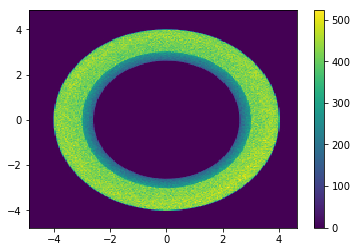

In [14]:
BDregion = np.where(sim.traj[:,3]==-1)[0]
obj = plt.hist2d(sim.traj[BDregion,1], sim.traj[BDregion,2], bins=200)
plt.colorbar()

In [15]:
class asym2DmilestoningMSMRD(object):
    def __init__(self, bathRadius, Ncenters):
        self.bathRadius = bathRadius
        self.Ncenters = Ncenters
        self.Nstates = Ncenters+1
    
    def getState(self, sample, prevstate):
        #check BD region first
        if sample[2] == -1:
            if np.linalg.norm(sample[:2]) > self.bathRadius:
                return self.Ncenters
            else:
                return prevstate
        else:
            if sample[2] < self.Ncenters:
                return sample[2]
            else:
                return prevstate
            
    def computeMilestoningTraj(self, traj):
        k = 0
        state = self.getState(traj[k], -2)
        while state == -2:
            k += 1
            state = self.getState(traj[k], -2)
        print k
        dTraj = []
        dTraj.append(self.getState(traj[k], -2))
        for i in range(k+1, len(traj)):
            state = self.getState(traj[i], dTraj[-1])
            if traj[i, 2] >= 0:
                for l in range(MSMlag):
                    dTraj.append(state)
            else:
                dTraj.append(state)
        self.dTraj = np.array(dTraj, dtype=int)
            
    def computeMeanTransitionTimes(self, timestep):
        sumTau = np.zeros((self.Nstates, self.Nstates))
        counts = np.zeros((self.Nstates, self.Nstates))
        tau = 0
        for i in range(len(self.dTraj)):
            if self.dTraj[i] == self.dTraj[i-1]:
                tau += 1
            else:
                sumTau[self.dTraj[i-1], self.dTraj[i]] += tau
                counts[self.dTraj[i-1], self.dTraj[i]] += 1
                tau = 0
        nonzeros = np.where(counts!=0)[0]
        self.meanTransitionTimes = np.zeros_like(counts)
        for i in range(0, int(self.Nstates)):
            for j in range(0, int(self.Nstates)):
                if counts[i,j] != 0:
                    self.meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
        self.counts = counts

In [16]:
def computeMeanTransitionTimes(timestep, mobj):
    sumTau = np.zeros((mobj.Nstates, mobj.Nstates))
    counts = np.zeros((mobj.Nstates, mobj.Nstates))
    i = 0
    tau = 0
    statesVisited = [mobj.dTraj[0]]
    transitionFrom = mobj.dTraj[0]
    nextTransitionIndex = -1
    while i<len(mobj.dTraj)-1:
        i += 1
        tau += 1
        if mobj.dTraj[i] != mobj.dTraj[i-1]:
            if len(statesVisited) == mobj.Nstates:
                transitionFrom = mobj.dTraj[nextTransitionIndex]
                statesVisited = [transitionFrom]
                i = nextTransitionIndex
                nextTransitionIndex = -1
                tau = 0
            elif not np.in1d(mobj.dTraj[i], statesVisited):
                sumTau[transitionFrom, mobj.dTraj[i]] += tau
                counts[transitionFrom, mobj.dTraj[i]] += 1
                if nextTransitionIndex < 0:
                    nextTransitionIndex = i
                statesVisited.append(mobj.dTraj[i])
    meanTransitionTimes = np.zeros((mobj.Nstates, mobj.Nstates))
    for i in range(0, mobj.Nstates):
        for j in range(0, mobj.Nstates):
            if counts[i,j] != 0:
                meanTransitionTimes[i,j] = sumTau[i,j] / counts[i,j] * timestep
    return meanTransitionTimes

In [17]:
milestoning = asym2DmilestoningMSMRD(3.0, 9)
milestoning.computeMilestoningTraj(sim.traj[:,1:4])

0


In [18]:
import pyemma
import pyemma.plots as mplt

In [19]:
# Obtained implied time scales using pyemma
its = pyemma.msm.its(milestoning.dTraj, lags = 20)

estimating MaximumLikelihoodMSM: 100% (7/7) [######################] eta 00:01 |

(array([ -2.5,   0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ]),
 <a list of 10 Text yticklabel objects>)

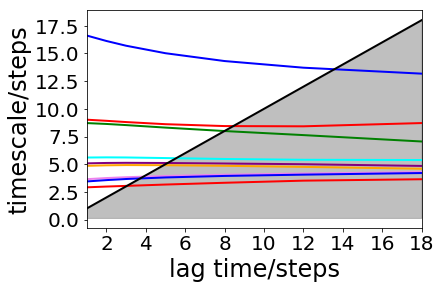

In [20]:
# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
#plt.xlim(0,900)
#plt.ylim(-100,1700)
#plt.xlim(0,100)
#plt.ylim(100,10000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [21]:
msm_MSMRD = pyemma.msm.estimate_markov_model(milestoning.dTraj, lag=1, reversible=False)

In [22]:
MTT_msm = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        MTT_msm[i,j] = msm_MSMRD.mfpt(i,j)*0.1

In [23]:
import pickle
BDtransitionTimesMSM = pickle.load(open('MTTs_convergence.p'))

[ 0.35138207  0.35673513  0.37266685  0.35221654  0.3843218   0.35226517
  0.35091328  0.36077208  0.36695652  0.        ]


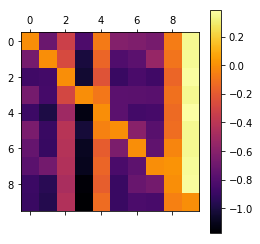

In [27]:
diff = np.zeros_like(MTT_msm)
for i in range(len(diff)):
    for j in range(len(diff)):
        if i != j:
            diff[i,j] = (MTT_msm[i,j] - BDtransitionTimesMSM[48][i,j])#/BDtransitionTimesMSM[48][i,j]
plt.matshow(diff, cmap=plt.get_cmap('inferno'))
#plt.clim((-0.2,0.3))
plt.colorbar()
np.amax(abs(diff))
#plt.savefig('2DasymError.pdf')
print diff[:,9]

In [31]:
BDtransitionTimesMSM[-1][2,9]

2.0997769072900434

In [28]:
stat_distr_reference = np.array([ 0.02885661,  0.03404936,  0.04002925,  0.03715941,  0.03915249,  0.03511926, 0.03510042,  0.03580847,  0.03664384,  0.67808089])

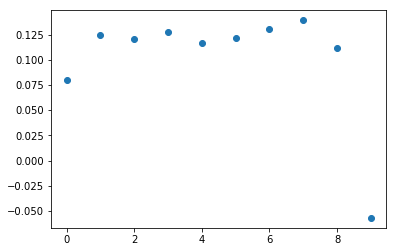

In [30]:
plt.plot((msm_MSMRD.stationary_distribution - stat_distr_reference)/stat_distr_reference, 'o')

In [32]:
inFlux4 = np.where(np.logical_and(sim.traj[:-1, 3] != -1, sim.traj[1:, 3] == -1))[0]

In [33]:
exits = np.where(np.logical_and(sim.traj[:-1,3] >= 0, sim.traj[1:,3]==-1))[0]
entries = np.where(np.logical_and(sim.traj[:-1,3] == -1, sim.traj[1:,3]>=0))[0]
innerEntries = np.where(np.logical_and(sim.traj[:-1,3] == -1, np.logical_and(sim.traj[1:,3]>=0, sim.traj[1:,3] < 9)))[0]

0.077293608007


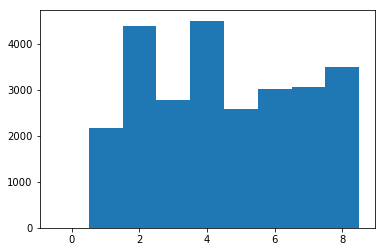

In [34]:
entriesHist = discreteHistogram(sim.traj[innerEntries+1, 3])
print len(innerEntries)/float(len(entries))

In [35]:
print sim.traj[1]
print model.parameters['NangularPartitions']

[  0.1   0.    0.   83. ]
12


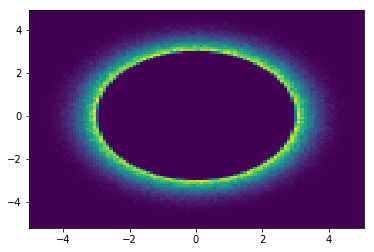

In [36]:
hist = plt.hist2d(sim.traj[exits+1, 1], sim.traj[exits+1, 2], bins = 100)

(array([ 6698.,  6652.,  6679.,  6578.,  6846.,  6668.,  6745.,  6749.,
         6725.,  6652.,  6785.,  6742.,  6676.,  6565.,  6655.,  6707.,
         6708.,  6670.,  6592.,  6599.,  6819.,  6842.,  6533.,  6838.,
         6641.,  6690.,  6596.,  6760.,  6717.,  6725.,  6620.,  6811.,
         6702.,  6715.,  6445.,  6779.,  6606.,  6905.,  6865.,  6750.,
         6942.,  6906.,  6856.,  6814.,  6787.,  6877.,  6706.,  6791.,
         6617.,  6763.]),
 array([ -1.79999801e+02,  -1.72799807e+02,  -1.65599813e+02,
         -1.58399818e+02,  -1.51199824e+02,  -1.43999830e+02,
         -1.36799836e+02,  -1.29599841e+02,  -1.22399847e+02,
         -1.15199853e+02,  -1.07999859e+02,  -1.00799864e+02,
         -9.35998700e+01,  -8.63998758e+01,  -7.91998815e+01,
         -7.19998872e+01,  -6.47998930e+01,  -5.75998987e+01,
         -5.03999044e+01,  -4.31999101e+01,  -3.59999159e+01,
         -2.87999216e+01,  -2.15999273e+01,  -1.43999331e+01,
         -7.19993878e+00,   5.54927997e-05,   

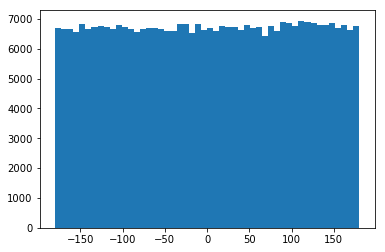

In [37]:
plt.hist(np.arctan2(sim.traj[exits+1, 1], sim.traj[exits+1, 2])*180./np.pi, bins=50)

128.0
141


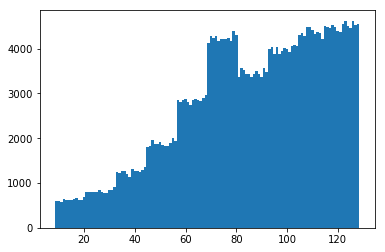

In [57]:
exitHist = discreteHistogram(sim.traj[exits, 3])
print np.amax(sim.traj[exits, 3])
print len(T)

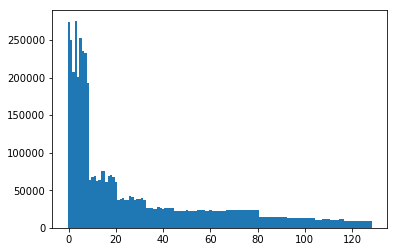

In [59]:
msmRegion = np.where(sim.traj[:,3] >-1)[0]
stat_distr = discreteHistogram(sim.traj[msmRegion,3])

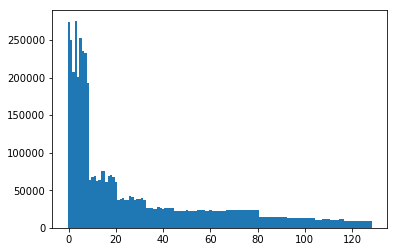

In [39]:
MSMregion = np.where(sim.traj[:,3]>=0)[0]
statDistr = discreteHistogram(sim.traj[MSMregion, 3])

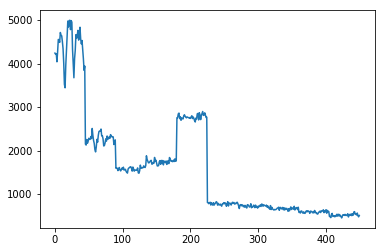

In [46]:
plt.plot(statDistr[0][0][9:])

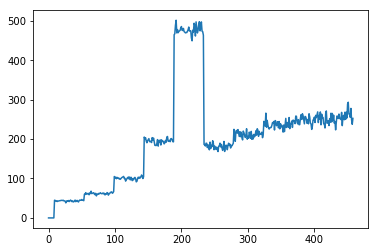

In [47]:
plt.plot(statDistr[0][0]*np.sum(T[:-45,-45:], axis=1))

AssertionError: Chosen set contains states that are not included in the active set.

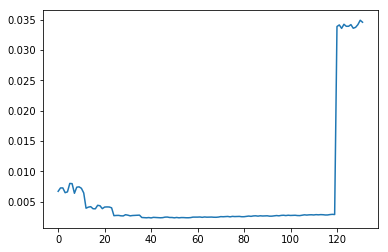

In [40]:
MSM = pyemma.msm.markov_model(T)
plt.plot(MSM.stationary_distribution[9:])
bathStates = [i for i in range(len(T)-m, 504)]
mfpt_fullMatrix = np.zeros((10,10))
for i in range(0, 9):
    mfpt_fullMatrix[i,9] = MSM.mfpt(i, bathStates) * 0.1
    mfpt_fullMatrix[9, i] = MSM.mfpt(bathStates, i) * 0.1
    for j in range(0,9):
        mfpt_fullMatrix[i,j] = MSM.mfpt(i,j) * 0.1

diff = np.zeros_like(MTT_msm)
for i in range(len(diff)):
    for j in range(len(diff)):
        if i != j:
            diff[i,j] = (MTT_msm[i,j] - mfpt_fullMatrix[i,j])/mfpt_fullMatrix[i,j]
plt.matshow(diff[:10,:10], cmap=plt.get_cmap('inferno'))
plt.colorbar()

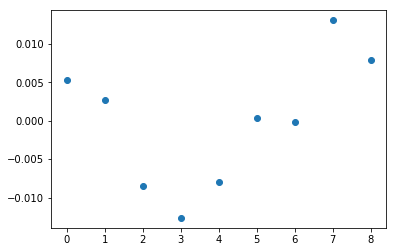

In [47]:
statDistrMSM = MSM.stationary_distribution[:9]/np.sum(MSM.stationary_distribution[:9]) 
statDistrHybrid = statDistr[0][0][:9]/np.sum(statDistr[0][0][:9])
plt.plot((statDistrMSM-statDistrHybrid)/statDistrMSM, 'o')

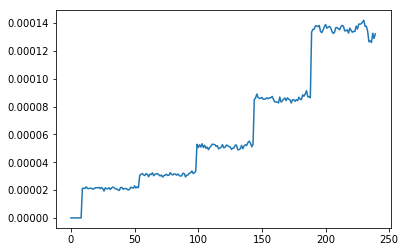

In [134]:
exitsMSM = plt.plot(MSM.stationary_distribution[:240]*np.sum(T[:240, -45:], axis=1))

In [48]:
referenceExitDistr = pickle.load(open('2DasymExitDistribution.p'))

In [61]:
MSMradius = 4.0
X = np.arange(3.0, 4.0, 0.01)
Zfull = np.zeros(X.shape[0]-1)
rad = np.linalg.norm(sim.traj[:,1:3], axis=1)
allExits = np.where(np.logical_and(rad[:-1]<3.0, rad[1:]>3.0))[0]
hist = np.histogram(rad[allExits+1], bins = X, normed=False)
Zfull += hist[0]
centers = (X[:-1] + X[1:]) /2.
#cp = plt.plot(centers, Zfull)
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
#plt.colorbar()

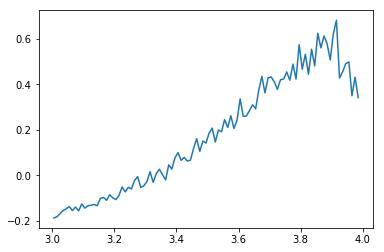

In [62]:
normalizedMSMRD = Zfull / np.sum(Zfull)
normalizedMD = referenceExitDistr / np.sum(referenceExitDistr)
plt.plot(centers, (normalizedMSMRD-normalizedMD)/normalizedMD)

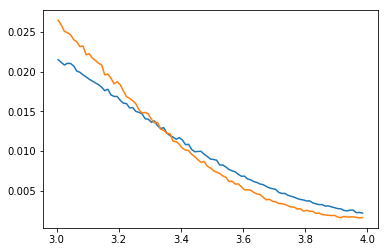

In [63]:
plt.plot(centers, normalizedMSMRD)
plt.plot(centers, normalizedMD)

In [77]:
print sim.traj[2]

[ 0.02       -1.74909968 -2.13589939 -1.        ]


In [54]:
print inFlux4.shape

(89892,)


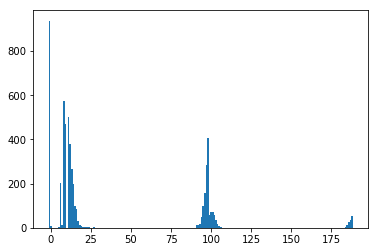

In [45]:
hist = discreteHistogram(sim.traj[inFlux4, 3])

In [51]:
selfFlux = np.where(np.logical_and(sim.traj[:-1, 3] == 4, sim.traj[1:, 3] == 4))[0]

In [52]:
print len(selfFlux)

31544


In [43]:
outFlux = np.where(np.logical_and(milestoning.dTraj[:-1] != 9, milestoning.dTraj[1:] == 9))[0]

In [44]:
print outFlux.shape

(16131,)


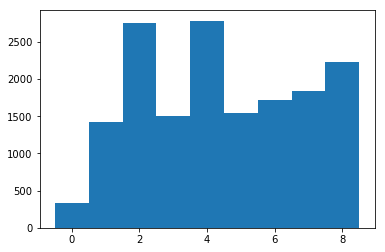

In [45]:
hist = discreteHistogram(milestoning.dTraj[outFlux])

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


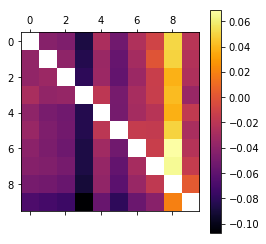

In [26]:
diff = (MTT_msm - BDtransitionTimesMSM[-1])/BDtransitionTimesMSM[-1]
plt.matshow(diff, cmap=plt.get_cmap('inferno'))
#plt.clim((-0.2,0.3))
plt.colorbar()
np.amax(diff)
plt.savefig('2DasymError.pdf')

/srv/public/dibakma/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


nan

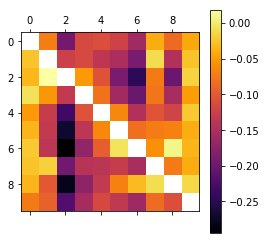

In [24]:
diff = (MTT - BDtransitionTimestraj)/BDtransitionTimestraj
plt.matshow(diff, cmap=plt.get_cmap('inferno'))
#plt.clim((-0.2,0.3))
plt.colorbar()
np.amax(diff)